#### Imports

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding

#### GPU Config

In [4]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(
                                    per_process_gpu_memory_fraction=0.8)
                                  # device_count = {'GPU': 1}
                                  )
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

### Datenset laden und vorbereiten

In [9]:
path = Path().resolve() / 'imdb_labelled.txt'
df = pd.read_csv(path, sep='\t', names=['review', 'label'], header=None)

# 0 == bad, 1 == good

print(df.head())
print(df['label'].unique())

                                              review  label
0  A very, very, very slow-moving, aimless movie ...      0
1  Not sure who was more lost - the flat characte...      0
2  Attempting artiness with black & white and cle...      0
3       Very little music or anything to speak of.        0
4  The best scene in the movie was when Gerardo i...      1
[0 1]


Größe des Vokabulars bestimmen

In [34]:
# alle wörter klein schreiben (jeder Satz endet mit ' ')
text = (df['review'] + ' ').str.lower()

# bilde einen großen Text (alle einzelnen Texte zusammengefasst)
text = text.sum()
# spalte nach wörtern
text = np.array(text.split())
# anzahl der einzigartigen einträge
voc_size = len(np.unique(text))
print(voc_size)

4004


Encoding der Texte  
Alle Sequenzen auf gleiche Länge bringen

In [63]:
features = df['review'].apply(one_hot, args=[voc_size])
# print(features)

# print(features.apply(len).sort_values().tail(15))

b_len = features.apply(len) < 80

features = features[b_len]
target = df.loc[b_len, 'label']

maxlen = features.apply(len).max()

features = pad_sequences(features, maxlen=maxlen, padding='pre')

print(features)

[[   0    0    0 ... 2817 2857 1461]
 [   0    0    0 ... 3749 3982  162]
 [   0    0    0 ... 2630  732  897]
 ...
 [   0    0    0 ... 3039  822 2992]
 [   0    0    0 ...    0  768 2220]
 [   0    0    0 ... 1423 2767 1157]]


### Modelierung

In [77]:
model = Sequential()
model.add(Embedding(voc_size + 1, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 73, 8)             32040     
_________________________________________________________________
flatten_4 (Flatten)          (None, 584)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 585       
Total params: 32,625
Trainable params: 32,625
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)

In [79]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 0s 13ms/step - loss: 0.6928 - acc: 0.4862 - val_loss: 0.6933 - val_acc: 0.4870
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6857 - acc: 0.5593 - val_loss: 0.6958 - val_acc: 0.4610
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6793 - acc: 0.5350 - val_loss: 0.6969 - val_acc: 0.4610
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6713 - acc: 0.5545 - val_loss: 0.6943 - val_acc: 0.4610
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6612 - acc: 0.5724 - val_loss: 0.6947 - val_acc: 0.4675
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6467 - acc: 0.8081 - val_loss: 0.6902 - val_acc: 0.5325
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6292 - acc: 0.9252 - val_loss: 0.6888 - val_acc: 0.5519
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6079 - 

20/20 [==============================] - 0s 6ms/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.7435 - val_acc: 0.5974
Epoch 64/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0226 - acc: 1.0000 - val_loss: 0.7470 - val_acc: 0.5909
Epoch 65/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.7473 - val_acc: 0.5909
Epoch 66/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0209 - acc: 1.0000 - val_loss: 0.7510 - val_acc: 0.5974
Epoch 67/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0202 - acc: 1.0000 - val_loss: 0.7543 - val_acc: 0.5974
Epoch 68/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0195 - acc: 1.0000 - val_loss: 0.7557 - val_acc: 0.5974
Epoch 69/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.7578 - val_acc: 0.5974
Epoch 70/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0181 - acc: 1

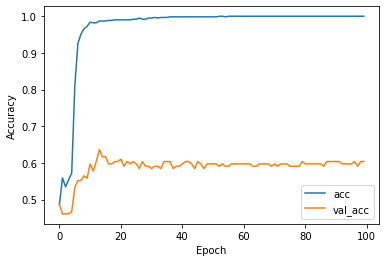

In [80]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()